In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
!python --version

Python 3.7.10


In [1]:
import os
import glob
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, Dataset, ImageDataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Resized,
    Spacing,
    Resize,
    AddChannel,
    NormalizeIntensity
)
from monai.utils import set_determinism
from monai.apps.mmars import RemoteMMARKeys
from monai.apps import download_and_extract
from monai.apps import load_from_mmar
import torch

print_config()

MONAI version: 0.6.0+38.gf6ad4ba5
Numpy version: 1.21.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: f6ad4ba5c2a6ecd8ab0ca18da1c20b0112a18d87

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0+cu111
tqdm version: 4.61.2
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.0
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
directory = "monai_data/"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

monai_data/


In [5]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [3]:
set_determinism(seed=0)

In [4]:
#resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task01_BrainTumour.tar"
#md5 = "240a19d752f0d9e9101544901065d872"

#compressed_file = os.path.join(root_dir, "Task01_Brain.tar")
#download_and_extract(resource, compressed_file, root_dir, md5)
data_dir = os.path.join(root_dir, "Task01_BrainTumour")

In [5]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTrT1w", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-100], data_dicts[-10:]

In [6]:
len(train_files)

384

In [7]:
len(val_files)

10

In [13]:
train_transforms = Compose( #Transformations for training dataset
    [
        LoadImaged(keys=["image", "label"]), #Load dictionary based images and labels
        EnsureChannelFirstd(keys=["image", "label"]), #Ensures the first channel of each image is the channel dimension
        Spacingd(keys=["image", "label"], pixdim=( #Change spacing of voxels to be same across images
            1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"), #Correct the orientation of images (Right, Anterior, Superior)
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        Resized(keys=["image", "label"], spatial_size=(74, 74, 48)),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        #ScaleIntensityRanged( #Scale intensity of all images (For images only and not labels)
        #    keys=["image"], a_min=-57, a_max=164,
        #    b_min=0.0, b_max=1.0, clip=True,
        #),
        #CropForegroundd(keys=["image", "label"], source_key="image"), #Crop foreground of image
        #RandCropByPosNegLabeld( #Randomly crop fixed sized region
        #    keys=["image", "label"],
        #    label_key="label",
        #    spatial_size=(96, 96, 96),
        #    pos=1,
        #    neg=1,
        #    num_samples=4,
        #    image_key="image",
        #    image_threshold=0,
        #),
        #RandAffined( #Do a random affine transformation with some probability
        #    keys=['image', 'label'],
        #    mode=('bilinear', 'nearest'),
        #    prob=0.5,
        #    spatial_size=(96, 96, 96),
        #    rotate_range=(np.pi/18, np.pi/18, np.pi/5),
        #    scale_range=(0.05, 0.05, 0.05)
        #),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [14]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [15]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(keys=["image", "label"], roi_size=[112, 112, 72], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [16]:
train_ds = Dataset(data=train_files, transform=train_transforms)

In [17]:
val_ds = Dataset(data=val_files, transform=val_transform)

In [18]:
train_ds[0]['image'].shape

torch.Size([1, 74, 74, 48])

In [19]:
train_ds[0]['label'].shape

torch.Size([1, 1, 74, 74, 48])

In [20]:
train_loader = DataLoader(train_ds, batch_size=20, num_workers=6, pin_memory=torch.cuda.is_available())

In [21]:
val_loader = DataLoader(val_ds, batch_size=1, num_workers=6, pin_memory=torch.cuda.is_available())

In [22]:
train_ds[0]['image'][0].shape

torch.Size([74, 74, 48])

In [23]:
data_dir

'monai_data/Task01_BrainTumour'

In [24]:
mmar = {
    RemoteMMARKeys.ID: "clara_pt_brain_mri_segmentation_t1c_1",
    RemoteMMARKeys.NAME: "clara_pt_brain_mri_segmentation_t1c",
    RemoteMMARKeys.FILE_TYPE: "zip",
    RemoteMMARKeys.HASH_TYPE: "md5",
    RemoteMMARKeys.HASH_VAL: None,
    RemoteMMARKeys.MODEL_FILE: os.path.join("models", "model.pt"),
    RemoteMMARKeys.CONFIG_FILE: os.path.join("config", "config_train.json"),
    RemoteMMARKeys.VERSION: 1,
}

In [25]:
PRETRAINED = True

In [26]:
device = torch.device("cpu")#"cuda:0" if torch.cuda.is_available() else "cpu")

if PRETRAINED:
    print("using a pretrained model.")
    unet_model = load_from_mmar(
        mmar, mmar_dir=root_dir,
        map_location=device,
        pretrained=True)
    model = unet_model
else:
    print("using a randomly init. model.")
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    )
model = model.to(device)

using a pretrained model.
Expected md5 is None, skip md5 check for file monai_data/clara_pt_brain_mri_segmentation_t1c_1.zip.
File exists: monai_data/clara_pt_brain_mri_segmentation_t1c_1.zip, skipped downloading.
Non-empty folder exists in monai_data/clara_pt_brain_mri_segmentation_t1c_1, skipped extracting.

*** "clara_pt_brain_mri_segmentation_t1c_1" available at monai_data/clara_pt_brain_mri_segmentation_t1c_1.
*** Model: <class 'monai.networks.nets.segresnet.SegResNet'>
*** Model params: {'blocks_down': [1, 2, 2, 4], 'blocks_up': [1, 1, 1], 'init_filters': 16, 'in_channels': 1, 'out_channels': 2, 'dropout_prob': 0.2}

---
For more information, please visit https://ngc.nvidia.com/catalog/models/nvidia:med:clara_pt_brain_mri_segmentation_t1c



In [25]:
max_epochs = 300
val_interval = 1
VAL_AMP = False

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
)

In [26]:
# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
#scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
#torch.backends.cudnn.benchmark = True

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_wt = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        #with torch.cuda.amp.autocast():
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    #lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_wt = metric_batch[0].item()
            metric_values_wt.append(metric_wt)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" wt: {metric_wt:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300


In [ ]:
2+2

In [ ]:
#model.eval()

In [122]:
train_ds[0]['image'].shape

torch.Size([1, 56, 56, 36])

In [123]:
train_ds[0]['label'].shape

torch.Size([1, 1, 56, 56, 36])

In [220]:
train_transforms = Compose( #Transformations for training dataset
    [
        LoadImaged(keys=["image", "label"]), #Load dictionary based images and labels
        EnsureChannelFirstd(keys=["image", "label"]), #Ensures the first channel of each image is the channel dimension
        Spacingd(keys=["image", "label"], pixdim=( #Change spacing of voxels to be same across images
            1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"), #Correct the orientation of images (Right, Anterior, Superior)
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        Resized(keys=["image", "label"], spatial_size=(80, 80, 48)),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        #ScaleIntensityRanged( #Scale intensity of all images (For images only and not labels)
        #    keys=["image"], a_min=-57, a_max=164,
        #    b_min=0.0, b_max=1.0, clip=True,
        #),
        #CropForegroundd(keys=["image", "label"], source_key="image"), #Crop foreground of image
        #RandCropByPosNegLabeld( #Randomly crop fixed sized region
        #    keys=["image", "label"],
        #    label_key="label",
        #    spatial_size=(96, 96, 96),
        #    pos=1,
        #    neg=1,
        #    num_samples=4,
        #    image_key="image",
        #    image_threshold=0,
        #),
        #RandAffined( #Do a random affine transformation with some probability
        #    keys=['image', 'label'],
        #    mode=('bilinear', 'nearest'),
        #    prob=0.5,
        #    spatial_size=(96, 96, 96),
        #    rotate_range=(np.pi/18, np.pi/18, np.pi/5),
        #    scale_range=(0.05, 0.05, 0.05)
        #),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [221]:
train_ds = Dataset(data=train_files, transform=train_transforms)

In [222]:
input0 = train_ds[0]['image'][0]

In [223]:
input0.shape

torch.Size([80, 80, 48])

In [224]:
test = torch.unsqueeze(torch.unsqueeze(input0,0),0)

In [225]:
test.shape

torch.Size([1, 1, 80, 80, 48])

In [226]:
#model.eval()

In [227]:
model.eval()
output0 = model(test)

In [228]:
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
test_outputs = [post_pred(i) for i in decollate_batch(output0)]

In [229]:
test_outputs[0].shape

torch.Size([2, 80, 80, 48])

In [230]:
outnp = output0.detach().numpy()

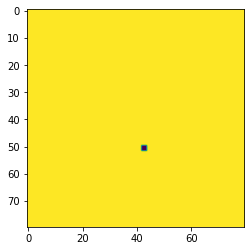

In [231]:
plt.imshow(test_outputs[0][0][:,:,24], cmap='viridis')

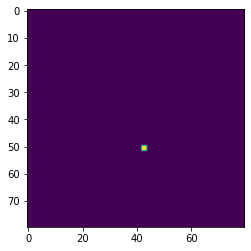

In [232]:
plt.imshow(test_outputs[0][1][:,:,24], cmap='viridis')

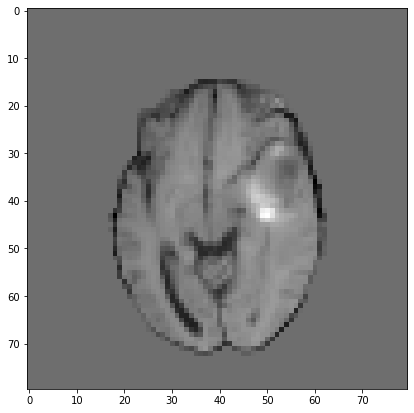

In [233]:
sliceval = 20
fig = plt.figure(frameon=False, figsize=(7,7))
plt.imshow(np.rot90(test[0][0][:,:,sliceval]), cmap='Greys_r')

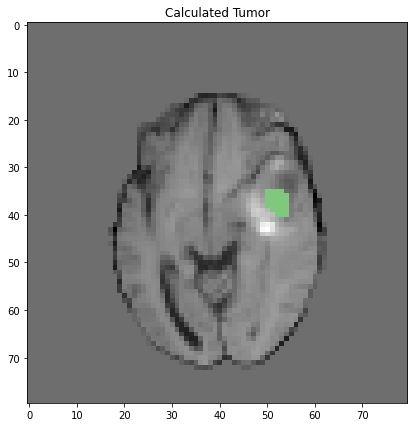

In [234]:
sliceval = 20
maskedTum = np.ma.masked_where(test_outputs[0][1][:,:,sliceval] == 0, test_outputs[0][1][:,:,sliceval])
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Calculated Tumor')
plt.imshow(np.rot90(test[0][0][:,:,sliceval]), cmap='Greys_r')
plt.imshow(np.rot90(maskedTum), cmap='Accent', alpha=1.0)

In [235]:
torch.save(model, '/home/jupyter/braintumor/brainTumor80_80_48.pth')

In [33]:
test[0][0][:,:,sliceval].max()

tensor(3.7062)

In [34]:
val_transforms = Compose( #Transformations for training dataset
    [
        Spacing(pixdim=(
            1.0, 1.0, 1.0), mode=("nearest")),
        AddChannel(),
        Resize((224,224,144)),
        #NormalizeIntensity(nonzero=True, channel_wise=True),
        AddChannel(),
        EnsureType()
    ]
)

In [35]:
t1w_images = ["monai_data/BrainTumourNift/test0.nii.gz", "monai_data/BrainTumourNift/BRATS_486.nii.gz"]

In [36]:
t1w_ds = ImageDataset(t1w_images[0:1], transform=val_transforms, ImageOnly=True)

In [37]:
t1w_ds[0][0].shape

torch.Size([1, 1, 224, 224, 144])

In [38]:
output = model(t1w_ds[0][0])

In [39]:
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
output_TC = [post_pred(i) for i in decollate_batch(output)]

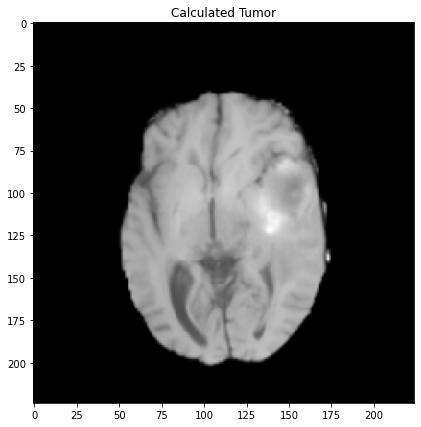

In [40]:
sliceval = 65
maskedTum = np.ma.masked_where(output_TC[0].numpy()[1][:,:,sliceval] == 0, output_TC[0].numpy()[1][:,:,sliceval])
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Calculated Tumor')
plt.imshow(np.rot90(t1w_ds[0][0].numpy()[0][0][:,:,sliceval]), cmap='Greys_r')
plt.imshow(np.rot90(maskedTum), cmap='Accent', alpha=1.0)

In [20]:
val_transforms = Compose( #Transformations for training dataset
    [
        Spacing(pixdim=(
            1.0, 1.0, 1.0), mode=("nearest")),
        AddChannel(),
        Resize((224,224,144)),
        NormalizeIntensity(nonzero=True, channel_wise=True),
        AddChannel(),
        EnsureType()
    ]
)

In [21]:
t1w_ds = ImageDataset(t1w_images[0:1], transform=val_transforms, ImageOnly=True)

NameError: name 't1w_images' is not defined

In [ ]:
output = model(t1w_ds[0][0])

In [ ]:
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
output_TC = [post_pred(i) for i in decollate_batch(output)]

In [ ]:
sliceval = 65
maskedTum = np.ma.masked_where(output_TC[0].numpy()[1][:,:,sliceval] == 0, output_TC[0].numpy()[1][:,:,sliceval])
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Calculated Tumor')
plt.imshow(np.rot90(t1w_ds[0][0].numpy()[0][0][:,:,sliceval]), cmap='Greys_r')
plt.imshow(np.rot90(maskedTum), cmap='Accent', alpha=1.0)

In [22]:
testimage = ['/home/jupyter/brain-kaggle/train/00000/T1wCE/']

In [23]:
t1w_ds = ImageDataset(testimage, transform=val_transforms)

In [24]:
t1w_ds[0][0].shape

torch.Size([1, 1, 224, 224, 144])

In [25]:
output = model(t1w_ds[0][0])

In [26]:
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
output_TC = [post_pred(i) for i in decollate_batch(output)]

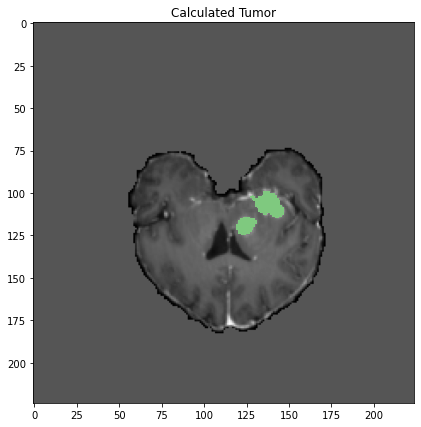

In [29]:
sliceval = 67
maskedTum = np.ma.masked_where(output_TC[0].numpy()[1][:,:,sliceval] == 0, output_TC[0].numpy()[1][:,:,sliceval])
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Calculated Tumor')
plt.imshow(np.rot90(t1w_ds[0][0].numpy()[0][0][:,:,sliceval]), cmap='Greys_r')
plt.imshow(np.rot90(maskedTum), cmap='Accent', alpha=1.0)